# Deploying the model

In [1]:
#1.First, we create an object of the Net class and load the store weights into the model
import torch.nn as nn
import numpy as np

#Then, we will define the helper function
def findConv2dOutShape(H_in, W_in, conv, pool=2):
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    
    H_out = np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out = np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    if pool:
        H_out /= pool
        W_out /= pool
    return int(H_out), int(W_out)
import torch.nn as nn
import torch.nn.functional as F

#Define the Net class
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in,H_in,W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w = findConv2dOutShape(H_in, W_in, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv4)
        
        #Compute the flatten size
        self.num_flatten = h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

params_model = {
    "input_shape":(3,96,96),
    "initial_filters":8,
    "num_fc1":100,
    "dropout_rate":0.25,
    "num_classes":2
}

cnn_model = Net(params_model)

In [2]:
#2.Let's load the state_dict into the model
import torch
path2weight = r"D:\my file\ptcv\ptcv2\models\weights1.pt"
cnn_model.load_state_dict(torch.load(path2weight))

<All keys matched successfully>

In [3]:
#3.Set the model in eval mode
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [4]:
#4.Move the model into CUDA device if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model.to(device)
    print("move to cuda")

move to cuda


In [5]:
#5.Let's develop a helper function to deploy the model on a dataset
def deploy_model(model, dataset, device, num_classes=2, sanity_check=False):
    len_data = len(dataset)
    y_out = torch.zeros(len_data, num_classes)
    y_gt = np.zeros((len_data), dtype="uint8")
    model = model.to(device)
    elapsed_times = []
    with torch.no_grad():
        for i in range(len_data):
            x,y = dataset[i]
            y_gt[i] = y
            start = time.time()
            y_out[i] = model(x.unsqueeze(0).to(device))
            elapsed = time.time() - start
            elapsed_times.append(elapsed)
            if sanity_check is True:
                break
    inference_time = np.mean(elapsed_times)*1000
    print("average inference time per image on %s : %.2f ms"%(device, inference_time))
    return y_out.numpy(), y_gt

In [46]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

#Don't forget to fix the random seed reproducibility
torch.manual_seed(0)

#Define histoCancerDataset class
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        path2data = os.path.join(data_dir, data_type)
        self.filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in self.filenames]
        
        csv_file = data_type + "_labels.csv"
        path2csvLabels = os.path.join(data_dir, csv_file)
        labels_df = pd.read_csv(path2csvLabels)
        labels_df.set_index("id", inplace=True)
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in self.filenames]
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

data_transformer = transforms.Compose([transforms.ToTensor()])

data_dir = r"D:\my file\ptcv\ptcv2\data"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
len(histo_dataset)
from torch.utils.data import random_split

len_histo = len(histo_dataset)
len_train = int(0.8*len_histo)
len_val = len_histo - len_train

train_ds, val_ds = random_split(histo_dataset, [len_train, len_val])

In [7]:
#6.Let's use the function to deploy the model on validation set
import time
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device, sanity_check=False)
print(y_out.shape, y_gt.shape)

average inference time per image on cuda : 1.22 ms
(44005, 2) (44005,)


In [10]:
#7.Let's check out the accuracy on validation set using the predicted model
from sklearn.metrics import accuracy_score

y_pred = np.argmax(y_out, axis=1)
print(y_pred.shape, y_gt.shape)

acc = accuracy_score(y_gt, y_pred)
print("accuracy", acc)

(44005,) (44005,)
accuracy 0.8799681854334734


In [11]:
#8.Let's also measure the inferece time on the CPU device
device_cpu = torch.device("cpu")
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device, sanity_check=False)
print(y_out.shape, y_gt.shape)

average inference time per image on cuda : 1.19 ms
(44005, 2) (44005,)


# Model inference on test data

In [12]:
#1.First, let's load the test_labels.csv and print out its head
path2csv = r"D:\my file\ptcv\ptcv2\data\test_labels.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [14]:
val_transformer = transforms.Compose([transforms.ToTensor()])

In [47]:
#2.Create a custom dataset for the test dataset
histo_test = histoCancerDataset(data_dir, val_transformer, data_type="test")
print(len(histo_test))

57458


In [19]:
#3.Deploy the model on the test dataset
y_test_out, _ = deploy_model(cnn_model, histo_test, device, num_classes=2, sanity_check=False)

y_test_pred = np.argmax(y_test_out, axis=1)
print(y_test_pred.shape)

average inference time per image on cuda : 1.21 ms
(57458,)


indices [ 2732 43567 42613 52416]
torch.Size([3, 100, 394])


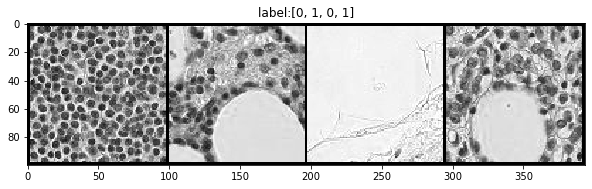

In [38]:
#4.Display some sample images and predictions
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)
np.random.seed(0)
def show(img, y, color=False):
    #convert a tensor to numpy array
    npimg = img.numpy()
    #convert to H*W*C shape
    npimg_tr = np.transpose(npimg, (1,2,0))
    if color == False:
        npimg_tr = npimg_tr[:,:,0]
        plt.imshow(npimg_tr, interpolation='nearest', cmap="gray")
    else:
        plt.imshow(npimg_tr, interpolation='nearest')
    plt.title("label:"+str(y))


grid_size = 4
rnd_inds = np.random.randint(0, len(y_test_pred), grid_size)
print("indices", rnd_inds)

x_grid = [histo_test[i][0] for i in rnd_inds]
y_grid = [y_test_pred[i] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.rcParams["figure.figsize"] = (10,5)
show(x_grid, y_grid)

In [40]:
print(y_test_out.shape)
cancer_pred = np.exp(y_test_out[:,1])
print(cancer_pred.shape)

(57458, 2)
(57458,)


In [60]:
path2sampleSub = r"D:\my file\ptcv\ptcv2\data" + "\sample_submission.csv"
sample_df = pd.read_csv(path2sampleSub)
ids_list = list(sample_df.id)
pred_list = [p for p in cancer_pred]
pred_dic = dict((key[:-4], value) for (key, value) in zip(histo_test.filenames, pred_list))
pred_list_sub = [pred_dic[id] for id in ids_list]
submission_df = pd.DataFrame({'id':ids_list, "label":pred_list_sub})
if not os.path.exists(r"D:\my file\ptcv\ptcv2\data\submissions"):
    os.mkdir(r"D:\my file\ptcv\ptcv2\data\submissions")
    print("submission folder created")
path2submission = r"D:\my file\ptcv\ptcv2\data\submissions\submission.csv"
submission_df.to_csv(path2submission, header=True, index=False)
submission_df.head()

submission folder created


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.046375
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.763656
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.105325
3,2c35657e312966e9294eac6841726ff3a748febf,0.265616
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.083400


In [58]:
for (key, value ) in zip(histo_test.filenames, pred_list):
    print(key[:-4], value)
    break

00006537328c33e284c973d7b39d340809f7271b 0.95616335
